# Imports

In [2]:
import os
import re
import shutil
import argparse
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from collections import defaultdict, Iterable


import json
import pandas as pd
from tqdm import tqdm


import cv2
from PIL import ImageDraw, ImageFont, Image

import torch
import torchvision
import torchvision.transforms as T
import torchvision.datasets as dset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


import albumentations as A
# from keras.models import model_from_json
# from keras.utils import multi_gpu_model
# from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard


# import tensorflow as tf

# import keras.backend as k
# from keras.layers import Dense, Activation
# from keras.layers import InputLayer, Input
# from keras.models import Sequential, Model, load_model
# from keras.layers import concatenate
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


In [1]:
!pip install keras==2.2.4
!pip install --upgrade albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)


In [3]:
!pip install scikit-learn==0.23.2

In [4]:
from tensorflow import keras
from tensorflow.keras.models import model_from_json
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [5]:
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.5.2
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.22
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
dlib==19.18.0
dm-tree==0.1.6
docopt==0.6.2
d

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/LukashNet/')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LukashNet/references')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LukashNet/distance_estimator')

In [8]:
from engine import train_one_epoch, evaluate
import utils

In [9]:
torch.cuda.is_available()

True

# Используемые функции

In [10]:
def show_image_and_bbox(image, bbox):
  to_pil = T.ToPILImage()
  image = np.array(to_pil(image))
  plt.imshow(image)
  bbox = bbox.numpy()
  for box in bbox:
    box = np.int0(box)
    box = [[box[0], box[1]],
            [box[2], box[1]],
            [box[2], box[3]],
            [box[0], box[3]]]
    box = np.array(box)
    image = cv2.drawContours(image, [box], 0, (0, 0, 255), 2)
  plt.imshow(image)
  plt.show()

In [11]:
class MyCocoDetection(dset.VisionDataset):
  def __init__(self, root, annFile, transform=None,
      target_transform=None, transforms=None, augmentation=False):
    super().__init__(root, transforms, transform, target_transform)
    from pycocotools.coco import COCO

    self.coco = COCO(annFile)
    self.ids = list(sorted(self.coco.imgs.keys()))
    self.augmentation = augmentation
    self.aug_transform = A.Compose([
                                    A.HorizontalFlip(p=0.5),
                                    A.HueSaturationValue(p=0.7),
                                    A.VerticalFlip(p=0.7),
                                    A.RandomRotate90(p=0.7)
                                    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),                                    ) 

  def _load_image(self, id: int):
    path = self.coco.loadImgs(id)[0]["file_name"]
    return Image.open(os.path.join(self.root, path)).convert("RGB")

  def _load_target(self, id):
    return self.coco.loadAnns(self.coco.getAnnIds(id))

  def __getitem__(self, index: int):
    id = self.ids[index]
    image = self._load_image(id)
    targets = self._load_target(id)


    # image, targets = super().__getitem__(index)
    target = dict()
    target = {}
    boxes = []
    labels = []
    area = []
    iscrowd = []

    for i in range(len(targets)):
      boxes.append(self.convert_to_xyxy(targets[i]['bbox']))
      labels.append(targets[i]['category_id'])
      area.append(targets[i]['area'])
      iscrowd.append(targets[i]['iscrowd'])

    if self.augmentation:
      augmented = self.aug_transform(image=np.array(image), bboxes=np.array(boxes), labels=np.array(labels))
      image = augmented['image']
      boxes = augmented['bboxes']
      labels = augmented['labels']


    target['boxes'] = torch.FloatTensor(boxes)
    target['labels'] = torch.tensor(labels, dtype=torch.int64)
    target['iscrowd'] = torch.tensor(iscrowd, dtype=torch.uint8)
    target['area'] = torch.tensor(area)
    target['image_id'] = torch.tensor([targets[0]['image_id']], dtype=torch.int64)

    if self.transforms is not None:
        image, target = self.transforms(image, target)
    return image, target
  
  def __len__(self) -> int:
    return len(self.ids)

  def convert_to_xyxy(self, boxes):
    xmin, ymin, weigth, height = boxes
    return [xmin, ymin, weigth + xmin, height + ymin]

In [12]:
def sorted_alphanumeric(data):
  convert = lambda text: int(text) if text.isdigit() else text.lower()
  alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
  return sorted(data, key=alphanum_key)

In [13]:
def read_annotation_file(filename):
  with open(os.path.join(data_root, filename)) as f:
    data_coco = json.load(f)
    current_coco = {'xmin': [],
                    'ymin': [],
                    'xmax': [],
                    'ymax': [],
                    'id': []}
    for annotation in data_coco['annotations']:
      xmin, ymin, w, h = annotation['bbox']
      current_coco['xmin'].append(xmin)
      current_coco['ymin'].append(ymin)
      current_coco['xmax'].append(xmin + w)
      current_coco['ymax'].append(ymin + h)
      current_coco['id'].append(annotation['image_id'])
  return pd.DataFrame(current_coco).set_index('id', inplace=False)

# Working on dataset


In [14]:
data_root = './drive/MyDrive/Colab Notebooks/LukashNet/data'
print(os.listdir(data_root))

['2021.04.21 - datasetV1.0', 'annotations', 'train', 'test', 'test_annotations', 'train_annotations', 'output_train.json', 'output_test.json', 'output.json', '2021.04.08 - datasetV1.0.xlsx', '2021.04.21_.pt', 'datafinalized_model.sav', 'finalized_model.sav', '2021.04.21_RForest_final.sav']


In [15]:
source_dir = os.path.join(data_root, '2021.04.21 - datasetV1.0')
train_dir = os.path.join(data_root, 'train')
train_ann = os.path.join(data_root, 'output_train.json')
test_dir = os.path.join(data_root, 'test')
test_ann = os.path.join(data_root, 'output_test.json')

In [16]:
test_ann_dir = os.path.join(data_root, 'test_annotations')
train_ann_dir = os.path.join(data_root, 'train_annotations')
ann_dir = os.path.join(data_root, 'annotations')

## Creating test and train directories

In [45]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for i, file_name in tqdm(enumerate(sorted_alphanumeric(os.listdir(source_dir)))):
  if i % 3 == 0:
    shutil.copy(os.path.join(source_dir, file_name), os.path.join(test_dir, file_name.replace('_MG_', '')))
  # else:
  #   shutil.copy(os.path.join(source_dir, file_name), os.path.join(train_dir, file_name.replace('_MG_', '')))

258it [00:33,  7.68it/s]


In [ ]:
print(len(os.listdir(test_dir)), len(os.listdir(train_dir)))

86 172


In [ ]:
os.makedirs(test_ann_dir, exist_ok=True)
os.makedirs(train_ann_dir, exist_ok=True)

for i, file_name in tqdm(enumerate(sorted_alphanumeric(os.listdir(ann_dir)))):
  if i % 3 == 0:
    shutil.copy(os.path.join(ann_dir, file_name), os.path.join(test_ann_dir, file_name))
  else:
    shutil.copy(os.path.join(ann_dir, file_name), os.path.join(train_ann_dir, file_name))

258it [00:03, 83.89it/s]


In [ ]:
print(len(os.listdir(test_ann_dir)), len(os.listdir(train_ann_dir)))

86 172


## Creating test and train dataloaders

In [17]:
test_dataset = MyCocoDetection(root = test_dir,
                               annFile = test_ann,
                               transform=T.ToTensor(),
                               augmentation=False,
                               )

train_dataset = MyCocoDetection(root = train_dir,
                                annFile = train_ann,
                                transform=T.ToTensor(),
                                augmentation=True,
                                )

print(len(test_dataset), len(train_dataset))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
86 172


Number of samples:  172
Image:  tensor([[[0.5529, 0.5529, 0.5569,  ..., 0.5882, 0.5765, 0.5804],
         [0.5608, 0.5529, 0.5569,  ..., 0.5961, 0.5922, 0.5843],
         [0.5608, 0.5529, 0.5569,  ..., 0.5882, 0.5922, 0.5882],
         ...,
         [0.2000, 0.2039, 0.2000,  ..., 0.3216, 0.3216, 0.3294],
         [0.1569, 0.1647, 0.1608,  ..., 0.3216, 0.3255, 0.3333],
         [0.1020, 0.1020, 0.1059,  ..., 0.3255, 0.3137, 0.3333]],

        [[0.5569, 0.5647, 0.5686,  ..., 0.5882, 0.5765, 0.5804],
         [0.5725, 0.5647, 0.5686,  ..., 0.5961, 0.5922, 0.5843],
         [0.5725, 0.5647, 0.5686,  ..., 0.5922, 0.5922, 0.5882],
         ...,
         [0.2039, 0.2078, 0.2039,  ..., 0.3373, 0.3373, 0.3333],
         [0.1490, 0.1569, 0.1647,  ..., 0.3373, 0.3412, 0.3373],
         [0.0941, 0.0980, 0.1020,  ..., 0.3412, 0.3294, 0.3373]],

        [[0.7216, 0.7137, 0.7176,  ..., 0.7529, 0.7412, 0.7451],
         [0.7216, 0.7137, 0.7176,  ..., 0.7608, 0.7569, 0.7490],
         [0.7216, 0.7137, 

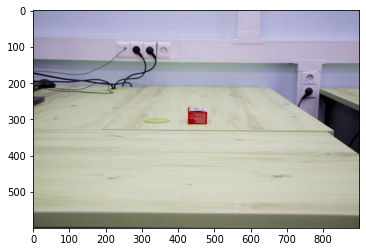

In [18]:
print('Number of samples: ', len(train_dataset))
img, target = train_dataset[0] # load 4th sample

print("Image: ", img)
plt.imshow(img.permute(1, 2, 0).numpy())
print(target)

In [19]:
rand_sampler = torch.utils.data.RandomSampler(train_dataset, num_samples=400, replacement=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=4,
                                               shuffle=False,
                                               sampler=rand_sampler,
                                               num_workers=2,
                                               collate_fn=utils.collate_fn
                                               )
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=2,
                                              collate_fn=utils.collate_fn
                                              )

print(len(test_dataloader), len(train_dataloader))

86 100


172


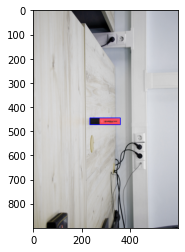

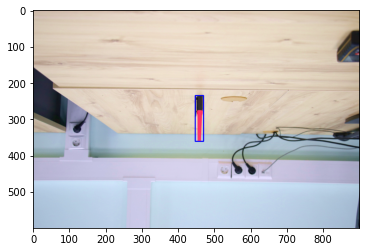

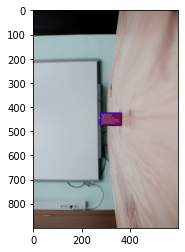

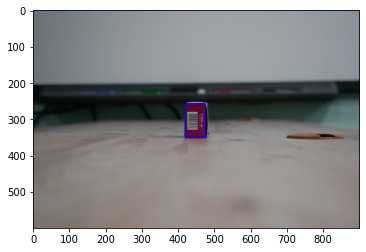

In [20]:
images, targets = next(iter(train_dataloader))
print(len(train_dataloader.dataset))
# print(targets)
for image, target in zip(images, targets):
  show_image_and_bbox(image, target['boxes'])

# Model

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                             progress=True)
num_classes = 2  # 1 class (box's side) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_dataloader, device=device)

torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/LukashNet/data/2021.04.21_.pt')

Epoch: [0]  [  0/100]  eta: 0:03:19  lr: 0.000055  loss: 0.8094 (0.8094)  loss_classifier: 0.6111 (0.6111)  loss_box_reg: 0.1023 (0.1023)  loss_objectness: 0.0680 (0.0680)  loss_rpn_box_reg: 0.0280 (0.0280)  time: 1.9917  data: 0.3291  max mem: 7570
Epoch: [0]  [ 10/100]  eta: 0:02:27  lr: 0.000560  loss: 0.5539 (0.5112)  loss_classifier: 0.3792 (0.3687)  loss_box_reg: 0.1023 (0.1034)  loss_objectness: 0.0200 (0.0312)  loss_rpn_box_reg: 0.0048 (0.0080)  time: 1.6419  data: 0.0417  max mem: 7833
Epoch: [0]  [ 20/100]  eta: 0:02:10  lr: 0.001065  loss: 0.2942 (0.4043)  loss_classifier: 0.1656 (0.2650)  loss_box_reg: 0.1155 (0.1105)  loss_objectness: 0.0095 (0.0224)  loss_rpn_box_reg: 0.0030 (0.0064)  time: 1.6100  data: 0.0138  max mem: 7833
Epoch: [0]  [ 30/100]  eta: 0:01:52  lr: 0.001569  loss: 0.2812 (0.3596)  loss_classifier: 0.1348 (0.2214)  loss_box_reg: 0.1158 (0.1151)  loss_objectness: 0.0070 (0.0179)  loss_rpn_box_reg: 0.0018 (0.0052)  time: 1.5834  data: 0.0148  max mem: 7833


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,
                                                             progress=True)
num_classes = 2  # 1 class (box's side) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
model.load_state_dict(torch.load('./drive/MyDrive/Colab Notebooks/LukashNet/data/2021.04.21_.pt',
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

  0%|          | 0/86 [00:00<?, ?it/s]

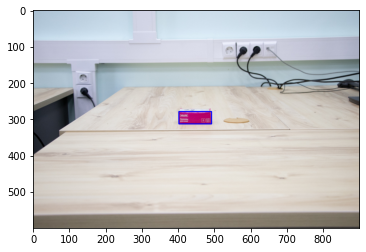

  1%|          | 1/86 [00:08<12:20,  8.72s/it]

KeyboardInterrupt: ignored

In [ ]:
model.eval()

model.to('cpu')

for data in tqdm(test_dataset):
  image = data[0].unsqueeze(0)
  image.to('cpu')
  predict = model(image)
  show_image_and_bbox(image.squeeze(0), predict[0]['boxes'].data)

# Distance estimator

In [23]:
distance_root = './drive/MyDrive/Colab Notebooks/LukashNet/distance_estimator'
distance_data_root = os.path.join(distance_root, 'data')
os.listdir(distance_data_root)

['total.csv',
 'test.csv',
 'train.csv',
 'predictions_from_RForest.csv',
 'predictions.csv']

## Creating dataset for testing from Faster-RCNN

In [54]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,
                                                             progress=True)
num_classes = 2  # 1 class (box's side) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('./drive/MyDrive/Colab Notebooks/LukashNet/data/2021.04.21_.pt',
                                 map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


<All keys matched successfully>

In [55]:
model.eval()

model.to('cpu')

output = {'xmin': [],
          'ymin': [],
          'xmax': [],
          'ymax': [],
          'image_id': []}
for data in tqdm(test_dataset):
  image = data[0].unsqueeze(0)
  image.to('cpu')
  predict = model(image)
  output['image_id'].append(data[1]['image_id'].data.numpy()[0])
  boxe = predict[0]['boxes'].detach().numpy()[np.argmax(predict[0]['scores'].detach().numpy(), axis=0)]
  output['xmin'].append(boxe[0])
  output['ymin'].append(boxe[1])
  output['xmax'].append(boxe[2])
  output['ymax'].append(boxe[3])

100%|██████████| 86/86 [09:34<00:00,  6.68s/it]


In [53]:
output

NameError: ignored

In [56]:
test_df = pd.DataFrame(output)
test_df['id'] = test_df['image_id']
test_df.set_index('image_id', inplace=True)
test_df['xmin'] = test_df['xmin'].astype(int)
test_df['ymin'] = test_df['ymin'].astype(int)
test_df['xmax'] = test_df['xmax'].astype(int)
test_df['ymax'] = test_df['ymax'].astype(int)


test_df['bbox\'s width'] = test_df['xmax'] - test_df['xmin']
test_df['bbox\'s height'] = test_df['ymax'] - test_df['ymin'] 

df = pd.read_excel(os.path.join(data_root, '2021.04.08 - datasetV1.0.xlsx')).drop(['Unnamed: 7', 'Unnamed: 8'], axis=1)
df['id'] = df['id'].str.replace('100-', '').astype(int)
df.set_index('id', inplace=True)

df['focus\' length'] = df['data of camera'].str.split(' ').str[-2].astype(int)
df['F'] = df['data of camera'].str.split(' ').str[1].str[1:-1].astype(float)

df['object\'s height'] = df['hlw'].str.split('x').str[0].astype(float).astype(int)
df['object\'s length'] = df['hlw'].str.split('x').str[1].astype(float).astype(int)
df['object\'s width'] = df['hlw'].str.split('x').str[0].astype(float).astype(int)

df['zloc'] = (df['distance'] * 1000).astype(int)

df['depicted width'] = df['depicted width'].astype(int)
df["depicted height"] = df['depicted height'].astype(int)


df = df.drop(['distance', 'hlw', 'data of camera', 'comment'], axis=1)

test_df = pd.concat([df.iloc[::3, :].copy(), test_df], axis=1)

test_df

,depicted width,depicted height,focus' length,F,object's height,object's length,object's width,zloc,xmin,ymin,xmax,ymax,id,bbox's width,bbox's height
2930,90,33,35,4.5,33,90,33,1331,401,279,491,313,2930,90,34
2933,154,41,35,4.5,41,154,41,1319,339,273,495,313,2933,156,40
2936,140,154,35,4.5,70,154,70,1303,384,210,524,361,2936,140,151
2939,130,65,35,4.5,17,130,17,1337,371,292,498,358,2939,127,66
2942,148,100,35,4.5,44,148,44,1341,386,259,529,358,2942,143,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3174,140,140,18,3.5,62,140,62,806,380,253,504,378,3174,124,125
3177,62,140,18,3.5,62,140,62,827,420,256,474,374,3177,54,118
3180,73,155,18,3.5,73,155,73,583,397,227,489,422,3180,92,195
3183,45,88,18,3.5,26,88,26,687,427,288,470,361,3183,43,73


## Creating dataset for training

In [ ]:
df = pd.read_excel(os.path.join(data_root, '2021.04.08 - datasetV1.0.xlsx')).drop(['Unnamed: 7', 'Unnamed: 8'], axis=1)
df.columns

Index(['id', 'distance', 'hlw', 'depicted width', 'depicted height',
       'data of camera', 'comment'],
      dtype='object')

In [ ]:
df

,id,distance,hlw,depicted width,depicted height,data of camera,comment
0,100-2930,1.332,33.9x90.6x54.5,90.6,33.9,"ISO=1250, F4.5, 200, 35 mm",под углом к главной оптической оси 10-20 граду...
1,100-2931,1.332,33.9x90.6x54.5,54.5,33.9,"ISO=1250, F4.5, 200, 35 mm",под углом к главной оптической оси 10-20 граду...
2,100-2932,1.332,33.9x90.6x54.5,90.6,54.5,"ISO=1250, F4.5, 200, 35 mm",под углом к главной оптической оси 10-20 граду...
3,100-2933,1.319,41.4x154x73.8,154.0,41.4,"ISO=1250, F4.5, 200, 35 mm",под углом к главной оптической оси 10-20 граду...
4,100-2934,1.314,41.4x154x73.8,73.8,41.4,"ISO=1250, F4.5, 200, 35 mm",под углом к главной оптической оси 10-20 граду...
...,...,...,...,...,...,...,...
253,100-3184,0.566,26.6x88.4x45.3,88.4,45.3,"ISO=1250, F3.5, 200, 18 mm",свет сзади-справа фотоаппарата \nпод углом к г...
254,100-3185,0.785,26.6x88.4x45.3,88.4,26.6,"ISO=1250, F3.5, 200, 18 mm",свет сзади-справа фотоаппарата \nпод углом к г...
255,100-3186,0.953,26.6x88.4x45.3,26.6,88.4,"ISO=1250, F3.5, 200, 18 mm",свет сзади-справа фотоаппарата \nпод углом к г...
256,100-3187,0.700,26.6x88.4x45.3,45.3,26.6,"ISO=1250, F3.5, 200, 18 mm",свет сзади-справа фотоаппарата \nпод углом к г...


In [ ]:
df['id'] = df['id'].str.replace('100-', '').astype(int)
df.set_index('id', inplace=True)

df['focus\' length'] = df['data of camera'].str.split(' ').str[-2].astype(int)
df['F'] = df['data of camera'].str.split(' ').str[1].str[1:-1].astype(float)

df['object\'s height'] = df['hlw'].str.split('x').str[0].astype(float).astype(int)
df['object\'s length'] = df['hlw'].str.split('x').str[1].astype(float).astype(int)
df['object\'s width'] = df['hlw'].str.split('x').str[0].astype(float).astype(int)

df = pd.concat([df, read_annotation_file('output.json')], axis=1)
df['bbox\'s width'] = df['xmax'] - df['xmin']
df['bbox\'s height'] = df['ymax'] - df['ymin'] 

df['zloc'] = (df['distance'] * 1000).astype(int)

df['depicted width'] = df['depicted width'].astype(int)
df["depicted height"] = df['depicted height'].astype(int)



df = df.drop(['distance', 'hlw', 'data of camera', 'comment'], axis=1)
df = df.iloc[:, list(range(2, 14)) + [0, 1]]

In [ ]:
test_df = df.iloc[::3, :].copy()
train_df = df.drop(df.iloc[::3, :].index, axis=0).copy()

In [ ]:
test_df

,focus' length,F,object's height,object's length,object's width,xmin,ymin,xmax,ymax,bbox's width,bbox's height,zloc,depicted width,depicted height
id,,,,,,,,,,,,,,
2930,35,4.5,33,90,33,402,281,489,314,87,33,1331,90,33
2933,35,4.5,41,154,41,342,272,494,316,152,44,1319,154,41
2936,35,4.5,70,154,70,385,211,525,363,140,152,1303,140,154
2939,35,4.5,17,130,17,369,296,498,359,129,63,1337,130,65
2942,35,4.5,44,148,44,385,261,528,357,143,96,1341,148,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3174,18,3.5,62,140,62,382,254,506,378,124,124,806,140,140
3177,18,3.5,62,140,62,420,256,475,378,55,122,827,62,140
3180,18,3.5,73,155,73,399,227,489,423,90,196,583,73,155


In [ ]:
train_df

,focus' length,F,object's height,object's length,object's width,xmin,ymin,xmax,ymax,bbox's width,bbox's height,zloc,depicted width,depicted height
id,,,,,,,,,,,,,,
2931,35,4.5,33,90,33,421,280,474,316,53,36,1331,54,33
2932,35,4.5,33,90,33,404,260,492,312,88,52,1331,90,54
2934,35,4.5,41,154,41,389,275,459,318,70,43,1313,73,41
2935,35,4.5,41,154,41,355,239,504,309,149,70,1347,154,73
2937,35,4.5,70,154,70,379,292,530,361,151,69,1327,154,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3182,18,3.5,73,155,73,395,259,505,384,110,125,902,137,155
3184,18,3.5,26,88,26,389,300,489,351,100,51,566,88,45
3185,18,3.5,26,88,26,404,313,481,337,77,24,785,88,26


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/LukashNet/distance_estimator/data/total.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/LukashNet/distance_estimator/data/test.csv', index=False)
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/LukashNet/distance_estimator/data/train.csv', index=False)

## Loading dataset

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LukashNet/distance_estimator/data/test.csv')
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LukashNet/distance_estimator/data/train.csv')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LukashNet/distance_estimator/data/total.csv')

## Methods of ml

In [60]:
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score#, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold 
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

### Visualize

In [32]:
!pip install opencv-python

In [84]:
def show_bboxes(params, save=False, show=True):
  fig = plt.figure(figsize=(6.4, 4.8), dpi=150)
  image = cv2.imread(os.path.join(test_dir, params['filename'][0]))
  

  start_point = tuple(params['top left'][0])
  end_point = tuple(params['bottom right'][0])
  score = (params['realw'][0] - params['predw'][0]) ** 2 / 2
  score += (params['realh'][0] - params['predh'][0]) ** 2 / 2

  image = cv2.rectangle(image, start_point, end_point, (255, 0, 0), 2)
  image = cv2.putText(image, 
                      f"ground truth-{params['realw'][0]}*{params['realh'][0]} mm*mm",
                      (start_point[0], start_point[1] - 10),
                      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                      fontScale=1,
                      color=(0, 255, 0),
                      thickness=2
                      )
  image = cv2.putText(image, 
                      f"prediction-{params['predw'][0]}*{params['predh'][0]} mm*mm",
                      (start_point[0], end_point[1] + 30),
                      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                      fontScale=1,
                      color=(255, 0, 0),
                      thickness=2
                      )
  image = cv2.putText(image, 
                      f'mse={score}',
                      (0, 30),
                      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                      fontScale=1,
                      color=(0, 0, 255),
                      thickness=2
                      )
  if save:
    predict_dir = os.path.join(data_root, 'predict')
    os.makedirs(predict_dir, exist_ok=True)
    cv2.imwrite(os.path.join(predict_dir, params['filename'][0]), image) 
    
  # cv2.imshow('detected circles', image)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()
  

  if show:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
  # plt.text(start_point[0], start_point[1] - 10, f"ground truth -{params['realw'][0]}x{params['realh'][0]}", c='g')
  # plt.text(start_point[0], end_point[1] + 30, f"prediction - {params['predw'][0]}x{params['predh'][0]}", c='r')
  # plt.text(0, 30, f'mse={score}')

  

In [77]:
df = pd.read_csv(os.path.join(distance_root, 'data/predictions.csv'))
df.columns

Index(['depicted width', 'depicted height', 'focus' length', 'F',
       'object's height', 'object's length', 'object's width', 'zloc', 'xmin',
       'ymin', 'xmax', 'ymax', 'id', 'bbox's width', 'bbox's height',
       'depicted height pred', 'depicted width pred'],
      dtype='object')

In [80]:
df

,xmin,ymin,xmax,ymax,depicted width,depicted height,depicted width pred,depicted height pred,path to img
0,401,279,491,313,90,33,74,35,2930.jpg
1,339,273,495,313,154,41,146,52,2933.jpg
2,384,210,524,361,140,154,109,121,2936.jpg
3,371,292,498,358,130,65,116,52,2939.jpg
4,386,259,529,358,148,100,122,69,2942.jpg
...,...,...,...,...,...,...,...,...,...
81,380,253,504,378,140,140,121,123,3174.jpg
82,420,256,474,374,62,140,46,100,3177.jpg
83,397,227,489,422,73,155,73,137,3180.jpg
84,427,288,470,361,45,88,33,67,3183.jpg


In [79]:
df = df.iloc[:, [8, 9, 10, 11, 0, 1, 16, 15]]
df['path to img'] = pd.DataFrame({'': os.listdir(test_dir)})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
for index, rows in df.iterrows():
  params = {'top left': [],
          'bottom right': [],
          'realw': [],
          'realh': [],
          'predw': [],
          'predh':[],
          'filename': []}
  params['top left'].append([rows[0], rows[1]])
  params['bottom right'].append([rows[2], rows[3]])
  params['realw'].append(rows[4])
  params['realh'].append(rows[5])
  params['predw'].append(rows[6])
  params['predh'].append(rows[7])
  params['filename'].append(rows[8])
  show_bboxes(params, save=True, show=False)

  # print(params)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

### Predict


In [61]:
X_test = test_df[['focus\' length', 'F', 
                  'xmin', 'ymin', 'xmax', 'ymax', 
                  'bbox\'s width', 'bbox\'s height']].copy()
y_test = test_df[['depicted width', 'depicted height']].copy()

In [62]:
X_test.shape, y_test.shape

((86, 8), (86, 2))

In [63]:
loaded_model = pickle.load(open('./drive/MyDrive/Colab Notebooks/LukashNet/data/2021.04.21_RForest_final.sav', 'rb'))

In [64]:
scalar = StandardScaler()
X_test = scalar.fit_transform(X_test)
y_test = scalar.fit_transform(y_test)

In [65]:
X_test, y_test

(array([[ 0.28521686,  0.10114914,  0.46009689,  0.52236404, -0.60950733,
         -1.85118139, -0.54512441, -1.01821685],
        [ 0.28521686,  0.10114914, -0.95713974,  0.42585854, -0.51402895,
         -1.85118139,  0.2427865 , -0.94608617],
        [ 0.28521686,  0.10114914,  0.07149975, -0.58744914,  0.1781893 ,
         -0.14962789,  0.0517778 ,  0.38833147],
        [ 0.28521686,  0.10114914, -0.22566277,  0.73145927, -0.44242016,
         -0.25597498, -0.10341678, -0.63351988],
        [ 0.28521686,  0.10114914,  0.11721706,  0.20067906,  0.29753727,
         -0.25597498,  0.08759193, -0.23680112],
        [ 0.28521686,  0.10114914,  0.89441134,  1.02097575, -0.75272489,
         -0.57501626, -0.84357551, -0.95810795],
        [ 0.28521686,  0.10114914,  1.32872579,  1.02097575, -1.39720395,
         -0.36232208, -1.39272554, -0.88597727],
        [ 0.28521686,  0.10114914,  0.64296613,  1.02097575, -0.87207287,
         -0.46866917, -0.77194725, -0.92204261],
        [ 0.2852

In [66]:
y_pred = loaded_model.predict(X_test)

In [67]:
y_pred = scalar.inverse_transform(y_pred).astype(int)
y_test = scalar.inverse_transform(y_test).astype(int)

In [68]:
y_pred, y_test

(array([[ 74,  35],
        [146,  52],
        [109, 121],
        [116,  52],
        [122,  69],
        [ 66,  40],
        [ 37,  47],
        [ 64,  36],
        [ 37,  50],
        [123, 116],
        [ 49, 112],
        [143,  51],
        [ 37,  68],
        [ 34,  78],
        [ 67,  32],
        [ 78,  38],
        [ 35,  78],
        [ 73,  32],
        [ 33,  58],
        [121,  57],
        [120,  45],
        [156,  90],
        [148,  55],
        [130, 131],
        [151,  71],
        [143,  64],
        [ 30, 123],
        [ 95, 122],
        [146,  62],
        [102,  47],
        [ 30, 109],
        [104,  48],
        [103,  42],
        [139, 136],
        [145,  61],
        [147,  56],
        [149,  42],
        [ 69,  38],
        [ 86,  36],
        [ 71,  34],
        [121,  52],
        [113, 124],
        [ 51,  45],
        [146,  49],
        [150,  89],
        [ 56,  94],
        [153,  78],
        [ 43, 123],
        [151, 142],
        [ 77, 144],


In [69]:
mean_squared_error(y_test.transpose()[0], y_pred.transpose()[0]), mean_squared_error(y_test.transpose()[1], y_pred.transpose()[1])

(351.0581395348837, 303.1744186046512)

In [70]:
df_result = test_df.copy()
# df_result['zloc_pred'] = y_pred
df_result['depicted height pred'] = y_pred.transpose()[1]
df_result['depicted width pred'] = y_pred.transpose()[0]


df_result.to_csv(os.path.join(distance_root, 'data/predictions.csv'), index=False)

### Train


In [ ]:
df.columns

Index(['focus' length', 'F', 'object's height', 'object's length',
       'object's width', 'xmin', 'ymin', 'xmax', 'ymax', 'bbox's width',
       'bbox's height', 'zloc', 'depicted width', 'depicted height'],
      dtype='object')

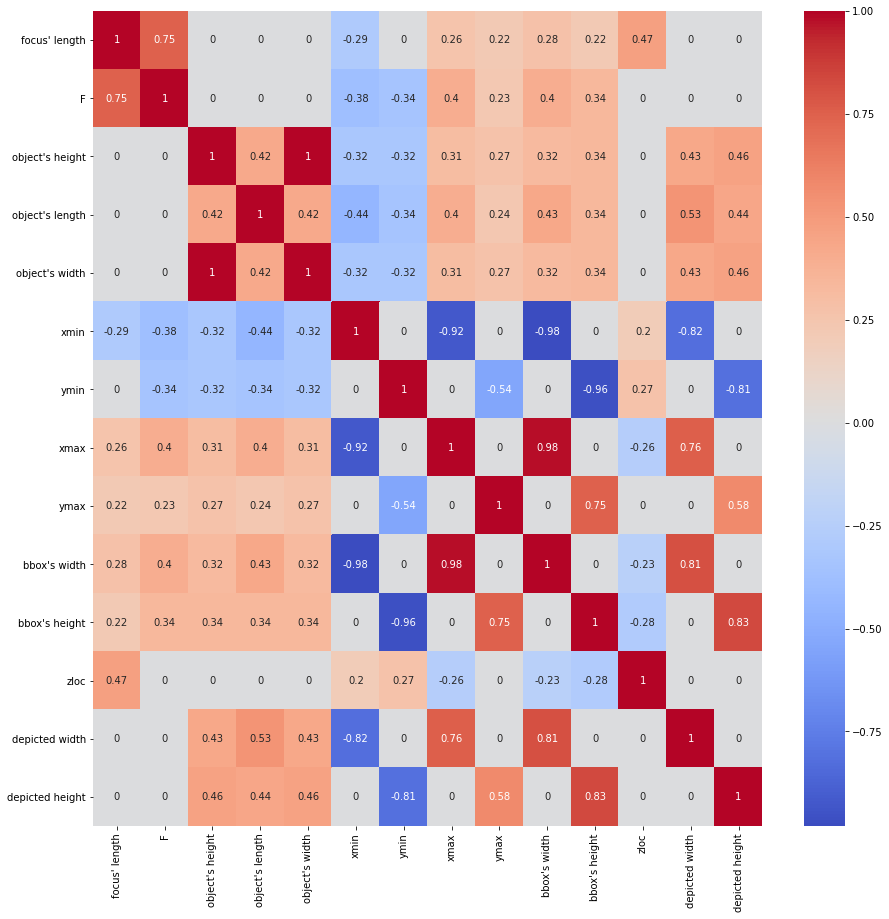

In [ ]:
plt.figure(figsize=(15, 15))

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

In [ ]:
X_train = train_df[['focus\' length', 'F', 
                    'xmin', 'ymin', 'xmax', 'ymax', 
                    'bbox\'s width', 'bbox\'s height']].copy()
y_train = train_df[['depicted width', 'depicted height']].copy()

X_test = test_df[['focus\' length', 'F', 
                  'xmin', 'ymin', 'xmax', 'ymax', 
                  'bbox\'s width', 'bbox\'s height']].copy()
y_test = test_df[['depicted width', 'depicted height']].copy()

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((172, 8), (172, 2), (86, 8), (86, 2))

In [ ]:
X_test

,focus' length,F,xmin,ymin,xmax,ymax,bbox's width,bbox's height
2930,35,4.5,401,279,491,313,90,34
2933,35,4.5,339,273,495,313,156,40
2936,35,4.5,384,210,524,361,140,151
2939,35,4.5,371,292,498,358,127,66
2942,35,4.5,386,259,529,358,143,99
...,...,...,...,...,...,...,...,...
3174,18,3.5,380,253,504,378,124,125
3177,18,3.5,420,256,474,374,54,118
3180,18,3.5,397,227,489,422,92,195
3183,18,3.5,427,288,470,361,43,73


In [ ]:
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
y_train = scalar.fit_transform(y_train)

In [ ]:
tree = RandomForestRegressor(n_estimators=20,
                             max_features='log2',
                             max_depth=18,
                             criterion='mse',
                             bootstrap=True,
                             random_state=17)

# tree.n_outputs = 2

# print(tree.n_outputs)

In [ ]:
cvs_tree = cross_val_score(tree, X_train, y_train, cv=5)

print(cvs_tree, np.round(np.mean(cvs_tree), 4))

[0.51583347 0.72858357 0.73480682 0.76513667 0.3956127 ] 0.628


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

In [ ]:
tree.fit(X_train, y_train)

RandomForestRegressor(max_depth=18, max_features='log2', n_estimators=20,
                      random_state=17)

In [ ]:
import pickle

filename = './drive/MyDrive/Colab Notebooks/LukashNet/data/finalized_model.sav'
pickle.dump(tree, open(filename, 'wb'))
 
some time later...
 
load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
loaded_model

RandomForestRegressor(max_depth=18, max_features='log2', n_estimators=20,
                      random_state=17)

In [ ]:
scalar = StandardScaler()
X_test = scalar.fit_transform(X_test)
y_test = scalar.fit_transform(y_test)

In [ ]:
y_pred = loaded_model.predict(X_test)

array([[-0.29045558,  1.27191172,  0.48430098,  0.63153978,  0.76125016,
        -0.46573987, -1.0757292 , -0.49144823, -1.07806632,  0.78578996,
        -0.83266832,  1.21582075, -1.07689776, -1.15168572, -0.4248402 ,
        -0.18645357, -1.13766298, -0.30681545, -1.1645399 ,  0.74255317,
         0.70632775,  1.49744418,  1.32566557,  0.92484883,  1.38058798,
         1.20880938, -1.22530513,  0.18164344,  1.27191172,  0.32070231,
        -1.24400212,  0.37211904,  0.34290499,  1.12116723,  1.27424885,
         1.29995721,  1.34202544, -0.38861478, -0.02051777, -0.34654655,
         0.74021604,  0.56610032, -0.78826296,  1.27074316,  1.37123949,
        -0.6643954 ,  1.43434183, -0.9436817 ,  1.39461073, -0.21449905,
         1.41213916, -1.23348506,  0.38497322, -0.94835595,  0.17696919,
        -1.14818004,  0.12905815, -1.06521214,  1.36656524, -0.29396127,
         1.17842677,  1.46939869, -0.87239942, -0.88759073,  0.06712437,
         0.55908894,  0.90498328,  0.19566618,  0.7

In [ ]:
y_pred = scalar.inverse_transform(y_pred).astype(int)
y_test = scalar.inverse_transform(y_test).astype(int)

In [ ]:
mean_squared_error(y_test.transpose()[0], y_pred.transpose()[0]), mean_squared_error(y_test.transpose()[1], y_pred.transpose()[1])

(355.27906976744185, 306.93023255813955)

In [ ]:
df_result = test_df.copy()
# df_result['zloc_pred'] = y_pred
df_result['depicted height pred'] = y_pred.transpose()[1]
df_result['depicted width pred'] = y_pred.transpose()[0]


df_result.to_csv(os.path.join(distance_root, 'data/predictions_from_RForest.csv'), index=False)

## Distance estimator

In [ ]:
# parse arguments
MODEL = 'model@1535470106.json'
WEIGHTS = 'model@1535470106.h5'

df_train = pd.read_csv(os.path.join(distance_data_root, 'train.csv'))

X_train = df_train[['xmin', 'ymin', 'xmax', 'ymax']].values
y_train = df_train[['zloc']].values
print(y_train)

# standardized data
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
y_train = scalar.fit_transform(y_train)

# load json and create model
json_file = open(os.path.join(distance_root,'generated_files', MODEL), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights(os.path.join(distance_root,'generated_files', WEIGHTS))
print("Loaded model from disk")

# compile and train model
# parallel_model = multi_gpu_model(model, gpus=2)
parallel_model = model
parallel_model.compile(loss='mean_squared_error', optimizer='adam')

modelname = 'model@' + (str(date.today()).replace('-', '.'))
tensorboard = TensorBoard(log_dir="logs/{}".format(modelname))

parallel_model.fit(X_train, y_train, validation_split=0.1, epochs=2000, batch_size=172, callbacks=[tensorboard], verbose=1)

# ----------- save model and weights ----------- #
model_json = model.to_json()
with open(os.path.join(distance_root,"generated_files/{}.json".format(modelname)), "w") as json_file:
    json_file.write(model_json)

model.save_weights(os.path.join(distance_root,"generated_files/{}.h5".format(modelname)))
print("Saved model to disk")

In [ ]:
# parse arguments
MODEL = 'model@2021.04.19.json'
WEIGHTS = 'model@2021.04.19.h5'

# get data
df_test = pd.read_csv(os.path.join(distance_data_root, 'test.csv'))
X_test = df_test[['xmin', 'ymin', 'xmax', 'ymax']].values
y_test = df_test[['zloc']].values

# standardized data
scalar = StandardScaler()
X_test = scalar.fit_transform(X_test)
y_test = scalar.fit_transform(y_test)

# load json and create model
json_file = open(os.path.join(distance_root,'generated_files', MODEL), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json( loaded_model_json )

# load weights into new model
loaded_model.load_weights(os.path.join(distance_root,'generated_files', WEIGHTS))
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
y_pred = loaded_model.predict(X_test)

# scale up predictions to original values
y_pred = scalar.inverse_transform(y_pred)
y_test = scalar.inverse_transform(y_test)

# save predictions
df_result = df_test
df_result['zloc_pred'] = -100000

for idx, row in df_result.iterrows():
  df_result.at[idx, 'zloc_pred'] = y_pred[idx]

df_result.to_csv(os.path.join(distance_root, 'data/predictions_from_NN.csv'), index=False)

Loaded model from disk
